**Punto A**

In [8]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt


from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn import set_config
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge



!curl -LJO https://raw.githubusercontent.com/mvera1412/TA136-TB056-TB057-8625/main/data/car_data.csv

car_data = pd.read_csv('car_data.csv', sep=',')
#car_data_backup = car_data.copy()

car_data = car_data.drop(['Car_Name', 'Owner'], axis=1)

#separo si es para entrenar, testear o validar y desecho la columna de set

x_train = car_data[car_data["Set"] == "Train"].drop('Set', axis=1)
y_train = car_data[car_data["Set"] == "Train"]['Selling_Price']

x_test = car_data[car_data["Set"] == "Test"].drop('Set', axis=1)
y_test = car_data[car_data["Set"] == "Test"]['Selling_Price']

x_val = car_data[car_data["Set"] == "Validation"].drop('Set', axis=1)
y_val = car_data[car_data["Set"] == "Validation"]['Selling_Price']


#separo las probabilidades de las variables categoricas

p_fuel = car_data['Fuel_Type'].value_counts(normalize=True)
p_seller = car_data['Seller_Type'].value_counts(normalize=True)
p_transmission = car_data['Transmission'].value_counts(normalize=True)
p_present_price = car_data['Present_Price'].value_counts(normalize=True)
p_year = car_data['Year'].value_counts(normalize=True)
p_kms_driven = car_data['Kms_Driven'].value_counts(normalize=True)

print(x_train.shape)
print(p_seller)
print(p_transmission)
#print(p_car_name)


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18812  100 18812    0     0  36643      0 --:--:-- --:--:-- --:--:-- 36670
(270, 7)
Seller_Type
Dealer        0.647841
Individual    0.352159
Name: proportion, dtype: float64
Transmission
Manual       0.86711
Automatic    0.13289
Name: proportion, dtype: float64


**Punto B**

La codificación One-Hot es una técnica utilizada para transformar variables categóricas en un formato numérico para que pueda ser interpretado por los algoritmos de aprendizaje automático.

Dada una variable categórica con $k$ posibles valores distintos, la codificación One-Hot representa cada categoría como un vector binario de dimensión $k$. En dicho vector, todas las posiciones toman valor $0$ excepto aquella que corresponde a la categoría presente, que toma valor $1$.


De esta manera, el algoritmo de aprendizaje no interpreta que una categoría es “mayor” o “menor” que otra, como sucedería si se asignaran valores numéricos enteros arbitrarios.

Esto evita introducir relaciones de orden inexistentes entre las categorías y permite trabajar de forma correcta con variables cualitativas.

En sklearn, la clase OneHotEncoderimplementa esta técnica. Además, permite optimizaciones tales como utilizar una sola columna en variables binarias opción drop='if\_binary', lo que evita redundancia en la representación.


In [9]:

encoder = OneHotEncoder(drop='if_binary', sparse_output=False)

categorical = ['Fuel_Type', 'Seller_Type', 'Transmission']

encoded = encoder.fit_transform(car_data[categorical])

print(encoded)




[[0. 0. 1. 0. 1.]
 [0. 1. 0. 0. 1.]
 [0. 0. 1. 0. 1.]
 ...
 [0. 0. 1. 0. 1.]
 [0. 1. 0. 0. 1.]
 [0. 0. 1. 0. 1.]]



### PolynomialFeatures

El transformador `PolynomialFeatures` de la librería `sklearn` permite generar un nuevo conjunto de variables a partir de las variables numéricas originales, creando combinaciones polinómicas de cierto grado especificado.

Dado un vector de características numéricas de dimensión $n$:

$$
\mathbf{x} = (x_1, x_2, \dots, x_n)
$$

`PolynomialFeatures` expande estas variables generando todos los términos polinómicos hasta un grado $d$. Esto incluye:

- Los términos originales $x_1, x_2, \dots, x_n$.  
- Los cuadrados y potencias hasta $d$: $x_1^2, x_2^2, \dots, x_n^d$.  
- Los productos cruzados: $x_1 x_2, \; x_1 x_3, \dots, x_{n-1}x_n$.  

En este caso por ejemplo si se elige $d=3$, entonces también aparecen términos cúbicos:

$$
(x_1, x_2) \;\;\longrightarrow\;\; (1, \; x_1, \; x_2, \; x_1^2, \; x_1 x_2, \; x_2^2, \; x_1^3, \; x_1^2 x_2, \; x_1 x_2^2, \; x_2^3)
$$

Este procedimiento permite que un modelo lineal pueda capturar relaciones no lineales entre las variables, ya que en el nuevo espacio polinómico la combinación lineal de los términos polinómicos equivale a un modelo no lineal en las variables originales.




In [10]:
# Columnas numéricas excepto la target
numerical = ['Kms_Driven' , 'Present_Price' , 'Year']

poly = PolynomialFeatures(degree=3, include_bias=False)

#creo el mapa polinomico de orden 3 sobre las variables numericas
poly_data = poly.fit_transform(car_data[numerical])

#combinatorio 6/3 me da 20 -1 de la fila de unos me da 19
print(poly_data.shape)

(301, 19)


In [11]:
#junto ambas transformaciones
X_combinado = np.hstack([poly_data, encoded])
print("Shape combinado:", X_combinado.shape)

#normalizo para que todo quede en la misma escala

scaler = StandardScaler()
x_normalizado = scaler.fit_transform(X_combinado)

print(x_normalizado.shape)


Shape combinado: (301, 24)
(301, 24)


**Punto C**:

En este caso lo que se hace es utilizar las mismas funciones del punto anterior pero dentro de la funcion `pipeline`la cual aplica una trasnformacion despues de la otra directamente en un solo paso, con la posibilidad de agregarle una ultima instancia de regresion lineal

In [12]:
#primero hago un pipeline con las tranformaciones para despues aplicarle la regresion lineal

preprocessor = ColumnTransformer(transformers=[('num', Pipeline([('poly', PolynomialFeatures(degree=3, include_bias=False)),('scaler', StandardScaler())]), numerical),
    ('cat', OneHotEncoder(drop='if_binary', sparse_output=False), categorical)
])


# Armamos el pipeline final con regresión lineal
model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('regressor', LinearRegression())
])




display(model)

#entreno el modelo

x_train = x_train.drop('Selling_Price', axis=1)
x_test = x_test.drop('Selling_Price', axis=1)
x_val = x_val.drop('Selling_Price', axis=1)

model.fit(x_train, y_train)

y_train_pred = model.predict(x_train)
y_val_pred = model.predict(x_val)

mse_train = np.mean((y_train - y_train_pred)**2)
mse_test = np.mean((y_val - y_val_pred)**2)


print("MSE entrenamiento:", mse_train)
print("MSE validación:", mse_test)


# cantidad de coeficientes
print("Coeficientes:", model.named_steps['regressor'].coef_.shape[0])

#19 son de las numericas y sus combinaciones y despues 5 de las categoricas


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures(degree=3,
                                                                                      include_bias=False)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Kms_Driven',
                                                   'Present_Price', 'Year']),
                                                 ('cat',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False),
                                                  ['Fuel_Type', 'Seller_Type',
                                                   'Transmission'])])),
                ('regressor', LinearRegression())])

MSE entrenamiento: 0.4726923559492935
MSE validación: 0.541999155333488
Coeficientes: 24


**Punto D**:

Regularizacion:


La regresión Ridge es una extensión de la regresión lineal que incorpora un término de regularización L2 para evitar el sobreajuste.  
El modelo busca minimizar la funcion de costo:

$$
\min_{\beta} \; \sum_{i=1}^N (y_i - \hat{y}_i)^2 + \lambda \sum_{j=1}^p \beta_j^2
$$

donde $\lambda$  controla la penalización sobre los coeficientes $\beta_j$ .  

- Si $\lambda$ es muy pequeño, el modelo se comporta como una regresión lineal común, poca penalizacion, con riesgo de **overfitting**.  
- Si $\lambda$ es muy grande, los coeficientes se reducen demasiado, lo que puede llevar a **underfitting** , solucion muy simple.  




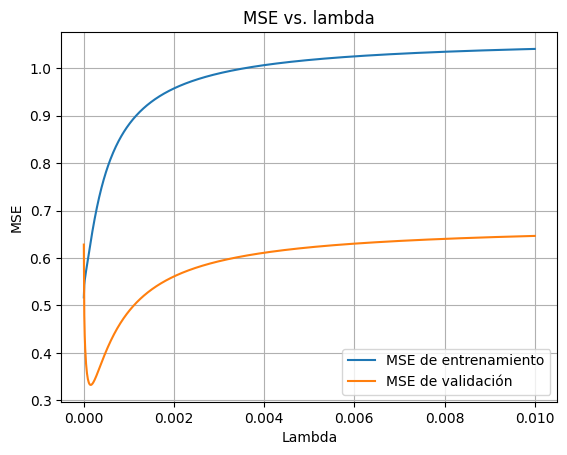

lambda que minimiza el error 0.00015113513513513515
MSE de entrenamiento 0.6333097526996495
MSE de validación 0.33251507736287805


'model_ridge.fit(x_train, y_train)\n\ny_train_pred = model_ridge.predict(x_train)\ny_test_pred = model_ridge.predict(x_test)\n\nmse_train = np.mean((y_train - y_train_pred)**2)\nmse_test = np.mean((y_test - y_test_pred)**2)\n\nprint("MSE entrenamiento Ridge:", mse_train)\nprint("MSE validación Ridge:", mse_test)\n\n'

In [13]:
#defino el modelo

model_ridge = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('regressor', Ridge(1e-6))
])


delta_l = np.linspace(1e-6, 1e-2, 1000)

mse_train_grafico = []
mse_test_grafico = []


for l in delta_l:
  model_ridge.set_params(regressor__alpha=l)
  model_ridge.fit(x_train, y_train)
  y_train_pred = model_ridge.predict(x_train)
  y_test_pred = model_ridge.predict(x_test)
  mse_train_grafico.append(np.mean((y_train - y_train_pred)**2))
  mse_test_grafico.append(np.mean((y_test - y_test_pred)**2))




plt.plot(delta_l, mse_train_grafico, label='MSE de entrenamiento')
plt.plot(delta_l, mse_test_grafico, label='MSE de validación')
#plt.xlim(-0.001 , 0.008)
plt.xlabel('Lambda')
plt.ylabel('MSE')
plt.title('MSE vs. lambda')
plt.legend()
plt.grid(True)
plt.show()

#busco el lambda que minimiza
minimo_validacion = np.argmin(mse_test_grafico)
print("lambda que minimiza el error" , delta_l[minimo_validacion])


#calculo los errores asociados a ese valor de lambda
error_train = mse_train_grafico[minimo_validacion]
error_test = mse_test_grafico[minimo_validacion]
print("MSE de entrenamiento", error_train)
print("MSE de validación", error_test)




"""model_ridge.fit(x_train, y_train)

y_train_pred = model_ridge.predict(x_train)
y_test_pred = model_ridge.predict(x_test)

mse_train = np.mean((y_train - y_train_pred)**2)
mse_test = np.mean((y_test - y_test_pred)**2)

print("MSE entrenamiento Ridge:", mse_train)
print("MSE validación Ridge:", mse_test)

"""

### Análisis de Resultados

Al observar las curvas del error cuadrático medio (MSE) en función de $\lambda$, se nota que:

- El error de entrenamiento aumenta a medida que crece $\lambda$, ya que la regularización reduce la capacidad del modelo para ajustarse a los datos.  
- El error de validación presenta una forma de "U": para valores muy pequeños de $\lambda$ el modelo sobreajusta (**overfitting**) y el error es alto; al aumentar $\lambda$ el error disminuye hasta alcanzar un valor mínimo y luego vuelve a crecer cuando la regularización es excesiva, debido a la simplicidad de la solucion, generando **underfitting**.  

De esta manera, el valor óptimo de $\lambda$ es aquel que minimiza el error en validación, y con él se reporta el error de testeo final. Esto confirma la importancia de la regularización para lograr un modelo con buena capacidad de generalización.
